In [1]:
!nvidia-smi

Tue Nov 30 15:59:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 30%   36C    P8    23W / 350W |     23MiB / 24267MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    On   | 00000000:21:00.0 Off |                  Off |
| 56%   

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Here we shall plot the number of samples in each class.\
In CIFAR100 dataset the samples are balanced at 500 samples per class.\
We will also define a function long tail that shall convert the\
balanced dataset into an unbalanced one given a dataset imbalance factor lamda.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def show_data_distribution(dataset, keyname="no name", classes=classes):
    dataset_elems = len(classes)*[0]
    for image, label in dataset:
        dataset_elems[label]+=1
    plt.bar(list(classes), dataset_elems)
    plt.title(keyname)
    plt.show()

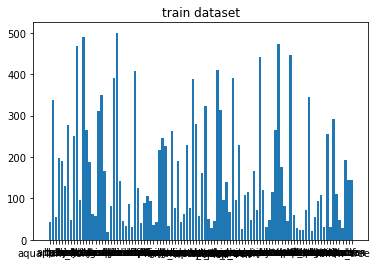

In [5]:
import random
def long_tail(dataset, classes=10, lamda=1):
    class_indices = list(range(classes))
    random.shuffle(class_indices)
    class_probs = [lamda ** x for x in class_indices]
    select_list = []
    for i, (img, label) in enumerate(dataset):
        if np.random.binomial(1, class_probs[label]):
            select_list.append(i)
    dataset.data=dataset.data[np.array(select_list)]
    dataset.targets=list(dataset.targets[x] for x in select_list)
    return dataset

imabalanced_trainset = long_tail(trainset, classes=len(trainset.classes), lamda = 0.97)
show_data_distribution(imabalanced_trainset, keyname="train dataset", classes=imabalanced_trainset.classes)

In the training loop, we will be providing the optimizer, model,\
dataloader and the criterion i.e the loss function. We shall\
calculate a running loss that averages over the entire epoch and logs the same

In [6]:
def train(trainloader, optimizer, net, criterion, epoch):
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            pass

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss = (running_loss*i + loss.item())/(i + 1)
        
    print("Finished Training Epoch :", epoch, " With the running loss : ", running_loss)
    return net

In [7]:
def test(testloader, net):
    net.eval()
    output_logs = []
    label_logs = []
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        if torch.cuda.is_available():
            inputs = inputs.cuda()
        else:
            pass
        
        labels = labels.numpy()
        outputs = torch.argmax(net(inputs), dim=1).cpu().detach().numpy()
        output_logs.append(outputs)
        label_logs.append(labels)
    print("Finished testing")
    return (np.concatenate(output_logs, axis=0), np.concatenate(label_logs, axis=0))

In the following function we shall feed all the outputs and the labels\
and the get metrics function shall return the following metrics of performance\
1. precision score class wise
2. max precision accross all class epochwise
3. min precision accross all class epochwise
4. mean precision *unweighted
5. recall score class wise
6. max recall accross all class epochwise
7. min recall accross all class epochwise
8. mean recall *unweighted
8. accuracy accross all class epochwise

In [8]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def get_metrics(outputs, labels):
    precision = precision_score(labels, outputs, average=None)
    max_precision = np.max(precision)
    min_precision = np.min(precision)
    mean_precision = np.mean(precision)
    
    recall = recall_score(labels, outputs, average=None)
    max_recall = np.max(recall)
    min_recall = np.min(recall)
    mean_recall = np.mean(recall)
    
    accuracy = accuracy_score(labels, outputs)
    return {
            "precision": precision,
            "recall": recall,
            "accuracy": accuracy,
            "max_precision": max_precision,
            "mean_precision": mean_precision,
            "min_precision": min_precision,
            "max_recall": max_recall,
            "mean_recall": mean_recall,
            "min_recall": min_recall
            }

In [9]:
def loop(trainloader, testloader, net, optimizer, criterion, epochs=50):
    logs = []
    for i in range(epochs):
        net = train(trainloader, optimizer, net, criterion, epoch=i)
        outputs, labels = test(testloader, net)
        metrics = get_metrics(outputs, labels)
        logs.append(metrics)
    return logs

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def plot_log(logs, lamda, num_classes=10, classes=classes):
    print(classes)
    precision = [x['precision'] for x in logs]
    recall = [x['recall'] for x in logs]
    accuracy = [x['accuracy'] for x in logs]

    len_logs = len(accuracy)

    max_precision = [x['max_precision'] for x in logs]
    min_precision = [x['min_precision'] for x in logs]
    mean_precision = [x['mean_precision'] for x in logs]

    max_recall = [x['max_recall'] for x in logs]
    min_recall = [x['min_recall'] for x in logs]
    mean_recall = [x['mean_recall'] for x in logs]

    plt.plot(list(range(len(max_precision))), max_precision, label = "max_precision")
    plt.plot(list(range(len(min_precision))), min_precision, label = "min_precision")
    plt.plot(list(range(len(mean_precision))), mean_precision, label = "mean_precision")

    plt.plot(list(range(len(max_recall))), max_recall, label = "max_recall")
    plt.plot(list(range(len(min_recall))), min_recall, label = "min_recall")
    plt.plot(list(range(len(mean_recall))), mean_recall, label = "mean_recall")
    
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.title(' min mean and max precision and recalls for class imbalance rate  '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()
    
    
    precision = np.array(precision)
    recall = np.array(recall)
    for i in range(num_classes):
        plt.plot(list(range(len_logs)), precision[:, i].tolist(), label = classes[i])
        
    plt.xlabel('Epochs')
    plt.ylabel('Precision classwise')
    plt.title('Class wise precision for lamda = '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()
    
    for i in range(num_classes):
        plt.plot(list(range(len_logs)), recall[:, i].tolist(), label = classes[i])
        
    plt.xlabel('Epochs')
    plt.ylabel('Recall classwise')
    plt.title('Class wise recall for lamda = '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(list(range(len(accuracy))), accuracy, label = "accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.title('Class wise accuracy for lamda = '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()

In [11]:
class Resnet18cifar(torch.nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.resnet18 = torch.hub.load('pytorch/vision:v0.8.0', 'resnet18', pretrained=pretrained)
        self.base = torch.nn.Sequential(*(list(self.resnet18.children())[:-1]))
        self.fc = torch.nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.base(x)
        x = x.reshape((-1, 512))
        x = self.fc(x)
        return x

/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Files already downloaded and verified
Files already downloaded and verified


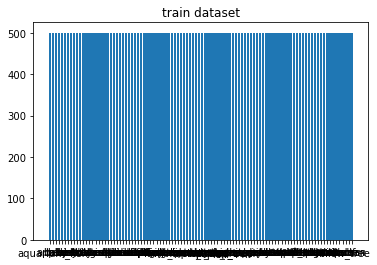

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


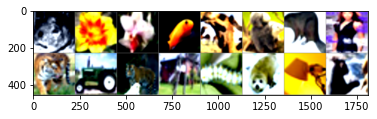

Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


mouse tulip orchid aquarium_fish camel possum beaver woman tiger tractor tiger house caterpillar  seal  lamp  bear
length of trainset 50000
Finished Training Epoch : 0  With the running loss :  3.887887621231087
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  3.2787983454513543
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 2  With the running loss :  2.8526075849914534
Finished testing
Finished Training Epoch : 3  With the running loss :  2.4944831076812726
Finished testing
Finished Training Epoch : 4  With the running loss :  2.193009495868684
Finished testing
Finished Training Epoch : 5  With the running loss :  1.9451743648147584
Finished testing
Finished Training Epoch : 6  With the running loss :  1.717373280601502
Finished testing
Finished Training Epoch : 7  With the running loss :  1.5071465825557706
Finished testing
Finished Training Epoch : 8  With the running loss :  1.3028128840827982
Finished testing
Finished Training Epoch : 9  With the running loss :  1.0978834326267242
Finished testing
Finished Training Epoch : 10  With the running loss :  0.8852371602678293
Finished testing
Finished Training Epoch : 11  With the running loss :  0.6775838676023488
Finished testing
Finished Training Epoch : 12  With the running loss :  0.49651487347483636
Finished testing
Finished

In [ ]:
import torchvision.transforms as transforms
import torch.optim as optim
import PIL

logs_by_lamda_resnet18_cifar100 = []
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = transforms.Compose([
    transforms.Resize(256, PIL.Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])



for lamda in [1.0, 0.995, 0.99, 0.985, 0.98, 0.975]:
    batch_size = 16
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform)
    trainset = long_tail(trainset, len(trainset.classes), lamda)
    show_data_distribution(trainset, keyname="train dataset", classes = trainset.classes)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=8)

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % trainset.classes[labels[j]] for j in range(batch_size)))
    print("length of trainset", len(trainset))

    net = Resnet18cifar(100, pretrained=False)
    if torch.cuda.is_available():
        net = net.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    logs = loop(trainloader, testloader, net, optimizer, criterion, epochs=200)
    logs_by_lamda_resnet18_cifar100.append({lamda: logs})

In [ ]:
for lamda in list(logs_by_lamda_resnet18_cifar10_transfer_learning.keys()):
    log = logs_by_lamda_resnet18_cifar100_transfer_learning[lamda]
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
    print("=" * 30)
    print("THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER")
    print("THE MODEL WAS NOT PRETRAINED")
    print("=" * 30)
    plot_log(log, lamda, num_classes=len(trainset.classes), classes=classes)